## OCR Report
This notebook constructs a proof-of-concept report of the district level data of Washington State schools, describing discipline and attendance information and highlighting disproportionate areas. See the README [here](https://github.com/CBofill/OCR-Discipline-and-Attendance-Visualization-Tool) for more information.

In [121]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [122]:
input_file = './data/NeedDistrict_Part2.csv'
output_file = './OCRReport.pdf'

In [123]:
# Import the data
df = pd.read_csv(input_file,index_col='SCH_ID')

In [124]:
df.replace('Yes', True, inplace=True)
df.replace('No', False, inplace=True)

In [125]:
## get list of grades
grades = [x.strip() for x in re.findall('SCH_GRADE_...', ' '.join(df.columns))]

## create variable for grades in a given school
school_grade_span = []
for row in df.iterrows():
    span = [re.sub('SCH_GRADE_', '', g) for g in grades if row[1][g]]
    school_grade_span.append((span[0], span[-1]))
## add grade span to data set
df['school_grade_span'] = pd.Series(school_grade_span, index=df.index)

## Enrollment
Enrollment is provided by race/ethnicity separated by gender, as an inclusive count of all students in the school. The number of these students who have disabilities (IDEA/504) is also provided by race/ethnicity.

The total for each race/ethnicity is calculated, as well as the total students enrolled in each school. This is repeated for students with disabilities.

Abbreviation-race pairs:

    - HI: Hispanic
    - AM: American Indian/ Alaksan Native
    - AS: Asian
    - HP: Native Hawaiian/Pacific Islander
    - BL: Black
    - WH: White
    - TR: Two or more

In [126]:
## get list of columns with enrollment data
enrollment_columns = [x for x in re.findall('SCH_ENR_.._[MF]', ' '.join(df.columns))]
enrollment_columns.extend(['school_grade_span'])

#get just enrollment data
enrollment_data = df.loc[:,enrollment_columns] 

#clean up names of columns
enrollment_data.columns = [re.sub('SCH_ENR_', '', x) for x in enrollment_data.columns]

# add columns representing all male and female members of given race
race_abbreviations = ['HI', 'AM', 'AS', 'HP', 'BL', 'WH', 'TR']
for r in race_abbreviations:
    enrollment_data[r] = enrollment_data[re.findall(r + '_.', ' '.join(enrollment_data.columns))].sum(axis=1)

# add column for male and female
gender = ['M', 'F']
for g in gender:
    enrollment_data[g] = enrollment_data[re.findall( r'\b.._' + g, ' '.join(enrollment_data.columns))].sum(axis=1)

# create df for presenting data
enrollment_data_clean = enrollment_data.ix[:,-9:]
enrollment_data_clean['total'] = enrollment_data_clean.iloc[:,-2:].sum(axis=1)

In [127]:
enrollment_data_clean

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,28,2,3,0,2,109,14,80,78,158
530003000010,134,10,1,1,2,183,26,168,189,357
530003000008,109,5,4,0,3,210,29,176,184,360
530003000011,185,25,16,0,9,248,37,274,246,520
530003000001,180,13,8,0,3,198,17,214,205,419
530003000009,119,30,13,2,6,268,18,218,238,456
530003000007,257,33,30,6,8,548,39,477,444,921
530003000002,25,5,1,1,4,62,8,58,48,106
530003002055,9,1,0,0,1,12,0,14,9,23


In [128]:
# repeat above for students with disabilities
enrollment_wdis_columns = [x for x in re.findall('SCH_(?:IDEA|504)ENR_.._[MF]', ' '.join(df.columns))]
enrollment_wdis_data = df.loc[:,enrollment_wdis_columns]
enrollment_wdis_data.columns = [re.sub('SCH_(?:IDEA|504)ENR_', '', x) for x in enrollment_wdis_data.columns]
for r in race_abbreviations:
    enrollment_wdis_data[r] = enrollment_wdis_data[re.findall(r + '_.', ' '.join(enrollment_data.columns))].sum(axis=1)
for g in gender:
    enrollment_wdis_data[g] = enrollment_wdis_data[re.findall(r'\b.._' + g, ' '.join(enrollment_data.columns))].sum(axis=1)

enrollment_wdis_clean = enrollment_wdis_data.ix[:,-9:]
enrollment_wdis_clean['total'] = enrollment_wdis_data.iloc[:,-2:].sum(axis=1)

In [129]:
enrollment_wdis_clean

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,4.0,1.0,0.0,0.0,0.0,9.0,4.0,12.0,6.0,18.0
530003000010,14.0,1.0,0.0,0.0,0.0,21.0,2.0,21.0,17.0,38.0
530003000008,15.0,2.0,2.0,0.0,1.0,23.0,5.0,33.0,15.0,48.0
530003000011,26.0,5.0,0.0,0.0,3.0,47.0,6.0,55.0,32.0,87.0
530003000001,31.0,6.0,1.0,0.0,0.0,37.0,5.0,50.0,30.0,80.0
530003000009,11.0,3.0,2.0,0.0,0.0,44.0,3.0,39.0,24.0,63.0
530003000007,47.0,11.0,3.0,1.0,1.0,99.0,8.0,103.0,67.0,170.0
530003000002,5.0,1.0,1.0,0.0,1.0,16.0,1.0,15.0,10.0,25.0
530003002055,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [130]:
# create df of students without disabilities
enrollment_wodis = enrollment_data_clean - enrollment_wdis_clean

In [131]:
enrollment_wodis

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,24.0,1.0,3.0,0.0,2.0,100.0,10.0,68.0,72.0,140.0
530003000010,120.0,9.0,1.0,1.0,2.0,162.0,24.0,147.0,172.0,319.0
530003000008,94.0,3.0,2.0,0.0,2.0,187.0,24.0,143.0,169.0,312.0
530003000011,159.0,20.0,16.0,0.0,6.0,201.0,31.0,219.0,214.0,433.0
530003000001,149.0,7.0,7.0,0.0,3.0,161.0,12.0,164.0,175.0,339.0
530003000009,108.0,27.0,11.0,2.0,6.0,224.0,15.0,179.0,214.0,393.0
530003000007,210.0,22.0,27.0,5.0,7.0,449.0,31.0,374.0,377.0,751.0
530003000002,20.0,4.0,0.0,1.0,3.0,46.0,7.0,43.0,38.0,81.0
530003002055,8.0,1.0,0.0,0.0,1.0,12.0,0.0,13.0,9.0,22.0


In [132]:
# Function to calculate data proportions based off values in 'total'. Returns df of same shape as input.
def calculate_proportions(df):
    data_proportions = df.copy()
    if 'total' not in data_proportions.columns:
        raise ValueError('Input must have \'total\' column')
    for column in data_proportions.columns:
        data_proportions[column] = data_proportions[column]*1.0 / data_proportions['total']
    return data_proportions

In [133]:
# get proportions for total enrollment, and students with and without disabilities
enrollment_proportions = calculate_proportions(enrollment_data_clean)
enrollment_wdis_proportions = calculate_proportions(enrollment_wdis_clean)
enrollment_wodis_proportions = calculate_proportions(enrollment_wodis)

In [134]:
# create df for presenting enrollment data
enrollment_presentation = enrollment_proportions.round(decimals=2)
enrollment_presentation.drop('total', axis=1, inplace=True)
enrollment_presentation

,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,
530003000005,0.18,0.01,0.02,0.00,0.01,0.69,0.09,0.51,0.49
530003000010,0.38,0.03,0.00,0.00,0.01,0.51,0.07,0.47,0.53
530003000008,0.30,0.01,0.01,0.00,0.01,0.58,0.08,0.49,0.51
530003000011,0.36,0.05,0.03,0.00,0.02,0.48,0.07,0.53,0.47
530003000001,0.43,0.03,0.02,0.00,0.01,0.47,0.04,0.51,0.49
530003000009,0.26,0.07,0.03,0.00,0.01,0.59,0.04,0.48,0.52
530003000007,0.28,0.04,0.03,0.01,0.01,0.60,0.04,0.52,0.48
530003000002,0.24,0.05,0.01,0.01,0.04,0.58,0.08,0.55,0.45
530003002055,0.39,0.04,0.00,0.00,0.04,0.52,0.00,0.61,0.39


## In-School Suspensions
In-school suspension data are provided by race/ethnicity separated by gender and students with and without disabilites. 

The percentage rate of students who received one or more in-school suspension is summed by race/ethnicity, then the composition index is calculated. Students with and without disabilities are considered separately.

In [135]:
## get list of columns with ISS data for students without disabilities
iss_wodis_columns = [x for x in re.findall('SCH_DISCWODIS_ISS_.._[MF]', ' '.join(df.columns))]
iss_wodis_columns.extend(['school_grade_span'])

#get just iss data
iss_wodis = df.loc[:,iss_wodis_columns]
#clean up names of columns
iss_wodis.columns = [re.sub('SCH_DISCWODIS_ISS_', '', x) for x in iss_wodis.columns]

# add columns representing all male and female members of given race
for r in race_abbreviations:
    iss_wodis[r] = iss_wodis[re.findall(r + '_.', ' '.join(iss_wodis.columns))].sum(axis=1)

# add column for male and female
gender = ['M', 'F']
for g in gender:
    iss_wodis[g] = iss_wodis[re.findall( '.._' + g, ' '.join(iss_wodis.columns))].sum(axis=1)

In [136]:
# get clean iss data
iss_wodis_clean = iss_wodis.iloc[:, -9:]
iss_wodis_clean['total'] = iss_wodis_clean.iloc[:,-2:].sum(axis=1)
iss_wodis_clean

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,0,0,0,0,0,1,0,1,0,1
530003000010,0,0,0,0,0,0,1,1,0,1
530003000008,0,0,0,0,0,0,0,0,0,0
530003000011,0,0,0,0,0,1,0,1,0,1
530003000001,0,0,0,0,0,3,0,3,0,3
530003000009,1,1,0,0,0,9,0,4,7,11
530003000007,8,3,0,2,3,24,6,33,13,46
530003000002,0,0,0,0,0,0,0,0,0,0
530003002055,0,0,0,0,0,0,0,0,0,0


In [137]:
# get iss proportions
iss_wodis_proportions = calculate_proportions(iss_wodis_clean)

In [138]:
# create df for displaying iss data
iss_wodis_presentation = iss_wodis_proportions.round(decimals=2)
iss_wodis_presentation.drop('total', axis=1, inplace=True)
iss_wodis_presentation

,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,
530003000005,0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000010,0.00,0.00,0.0,0.00,0.00,0.00,1.00,1.00,0.00
530003000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000011,0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000001,0.00,0.00,0.0,0.00,0.00,1.00,0.00,1.00,0.00
530003000009,0.09,0.09,0.0,0.00,0.00,0.82,0.00,0.36,0.64
530003000007,0.17,0.07,0.0,0.04,0.07,0.52,0.13,0.72,0.28
530003000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003002055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [139]:
# repeat for students with disabilities
iss_wdis_columns = [x for x in re.findall('SCH_DISCWDIS_ISS_(?:IDEA|504)_.._[MF]', ' '.join(df.columns))]
iss_wdis_columns.extend(['school_grade_span'])
iss_wdis = df.loc[:,iss_wdis_columns]
iss_wdis.columns = [re.sub('SCH_DISCWDIS_ISS_(?:IDEA|504)_', '', x) for x in iss_wdis.columns]
for r in race_abbreviations:
    iss_wdis[r] = iss_wdis[re.findall(r + '_.', ' '.join(iss_wdis.columns))].sum(axis=1)
for g in gender:
    iss_wdis[g] = iss_wdis[re.findall( '.._' + g, ' '.join(iss_wdis.columns))].sum(axis=1)

In [140]:
# TODO: Decide how to represent students with disablities
# Race/ethnicity data is only given for IDEA students, meaning we can't give composition calculations for 504 students

## Out-of-School Suspensions
Out-of-school suspension data are provided by race/ethnicity separated by gender, students with and without disabilities, and students receiving only one or more than one suspension. 

The percentage rate of students without disabilities who received one or more out-of-school suspension is calculated by race/ethnicity, and the composition index is calculated.

In [141]:
## get list of columns with OOS suspension data for students without disabilities
oos_wodis_columns = [x for x in re.findall('SCH_DISCWODIS_(?:SING|MULT)OOS_.._[MF]', ' '.join(df.columns))]
oos_wodis_columns.extend(['school_grade_span'])

#get just oos data
oos_wodis = df.loc[:,oos_wodis_columns]
#clean up names of columns
oos_wodis.columns = [re.sub('SCH_DISCWODIS_(?:SING|MULT)OOS_', '', x) for x in oos_wodis.columns]
oos_wodis = oos_wodis.groupby(by = oos_wodis.columns, axis=1).sum()

# add columns representing all male and female members of given race
for r in race_abbreviations:
    oos_wodis[r] = oos_wodis[re.findall(r + '_.', ' '.join(oos_wodis.columns))].sum(axis=1)

# add column for male and female
gender = ['M', 'F']
for g in gender:
    oos_wodis[g] = oos_wodis[re.findall( '.._' + g, ' '.join(oos_wodis.columns))].sum(axis=1)

In [142]:
# get clean oos data
oos_wodis_clean = oos_wodis.iloc[:, -9:]
oos_wodis_clean['total'] = oos_wodis_clean.iloc[:,-2:].sum(axis=1)
oos_wodis_clean

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,1,0,0,0,0,2,2,4,1,5
530003000010,0,0,0,0,0,1,1,2,0,2
530003000008,1,0,0,0,0,6,0,6,1,7
530003000011,1,1,1,0,0,3,1,7,0,7
530003000001,1,2,0,0,0,5,1,7,2,9
530003000009,2,1,0,0,0,11,1,7,8,15
530003000007,12,0,0,0,1,14,2,17,12,29
530003000002,1,2,0,0,0,3,0,4,2,6
530003002055,0,0,0,0,0,0,0,0,0,0


In [143]:
# get oos proportions
oos_wodis_proportions = calculate_proportions(oos_wodis_clean)

In [144]:
# create df for displaying oos data
oos_wodis_presentation = oos_wodis_proportions.round(decimals=2)
oos_wodis_presentation.drop('total', axis=1, inplace=True)
oos_wodis_presentation

,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,
530003000005,0.20,0.00,0.00,0.0,0.00,0.40,0.40,0.80,0.20
530003000010,0.00,0.00,0.00,0.0,0.00,0.50,0.50,1.00,0.00
530003000008,0.14,0.00,0.00,0.0,0.00,0.86,0.00,0.86,0.14
530003000011,0.14,0.14,0.14,0.0,0.00,0.43,0.14,1.00,0.00
530003000001,0.11,0.22,0.00,0.0,0.00,0.56,0.11,0.78,0.22
530003000009,0.13,0.07,0.00,0.0,0.00,0.73,0.07,0.47,0.53
530003000007,0.41,0.00,0.00,0.0,0.03,0.48,0.07,0.59,0.41
530003000002,0.17,0.33,0.00,0.0,0.00,0.50,0.00,0.67,0.33
530003002055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# TODO: Repeat for students with disabilities

## Expulsions
Expulsions data are provided by race/ethnicity separated by gender, students with and without disabilities, and students who received an expulsion with or without educational services. The percentage rate of students who received an expulsion is summed by race/ethnicity, and the composition index is calculated.

In [146]:
## get list of columns with expulsion data for students without disabilities
exp_wodis_columns = [x for x in re.findall('SCH_DISCWODIS_EXPWO?E_.._[MF]', ' '.join(df.columns))]
exp_wodis_columns.extend(['school_grade_span'])

#get just expulsion data
exp_wodis = df.loc[:,exp_wodis_columns]
#clean up names of columns
exp_wodis.columns = [re.sub('SCH_DISCWODIS_EXPWO?E_', '', x) for x in exp_wodis.columns]
exp_wodis = exp_wodis.groupby(by = exp_wodis.columns, axis=1).sum()

# add columns representing all male and female members of given race
for r in race_abbreviations:
    exp_wodis[r] = exp_wodis[re.findall(r + '_.', ' '.join(exp_wodis.columns))].sum(axis=1)

# add column for male and female
gender = ['M', 'F']
for g in gender:
    exp_wodis[g] = exp_wodis[re.findall( '.._' + g, ' '.join(oos_wodis.columns))].sum(axis=1)

In [147]:
# get clean expulsion data
exp_wodis_clean = exp_wodis.iloc[:, -9:]
exp_wodis_clean['total'] = exp_wodis_clean.iloc[:,-2:].sum(axis=1)
exp_wodis_clean

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,0,0,0,0,0,0,0,0,0,0
530003000010,0,0,0,0,0,0,0,0,0,0
530003000008,0,0,0,0,0,0,0,0,0,0
530003000011,0,0,0,0,0,0,0,0,0,0
530003000001,0,0,0,0,0,0,0,0,0,0
530003000009,0,0,0,0,0,0,0,0,0,0
530003000007,0,0,0,0,0,0,0,0,0,0
530003000002,0,0,0,0,0,0,0,0,0,0
530003002055,0,0,0,0,0,0,0,0,0,0


In [148]:
# get expulsion proportions
exp_wodis_proportions = calculate_proportions(exp_wodis_clean)

In [149]:
# create df for displaying expulsion data
exp_wodis_presentation = exp_wodis_proportions.round(decimals=2)
exp_wodis_presentation.drop('total', axis=1, inplace=True)
exp_wodis_presentation

,HI,AM,AS,HP,BL,WH,TR,M,F
SCH_ID,,,,,,,,,
530003000005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003002055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [150]:
# TODO: Repeat for students with disabilities

## Visualization

A simple report showing the composition index. This index is a comparison of the proportions of disciplinary actions and enrollment by demographic, in this case race/ethnicity.

First we'll take a look at the proportions themselves.

In [151]:
iss_wodis_proportions

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0
530003000010,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0
530003000008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003000011,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0
530003000001,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.0
530003000009,0.090909,0.090909,0.0,0.000000,0.000000,0.818182,0.000000,0.363636,0.636364,1.0
530003000007,0.173913,0.065217,0.0,0.043478,0.065217,0.521739,0.130435,0.717391,0.282609,1.0
530003000002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
530003002055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [152]:
enrollment_wodis_proportions

,HI,AM,AS,HP,BL,WH,TR,M,F,total
SCH_ID,,,,,,,,,,
530003000005,0.171429,0.007143,0.021429,0.000000,0.014286,0.714286,0.071429,0.485714,0.514286,1.0
530003000010,0.376176,0.028213,0.003135,0.003135,0.006270,0.507837,0.075235,0.460815,0.539185,1.0
530003000008,0.301282,0.009615,0.006410,0.000000,0.006410,0.599359,0.076923,0.458333,0.541667,1.0
530003000011,0.367206,0.046189,0.036952,0.000000,0.013857,0.464203,0.071594,0.505774,0.494226,1.0
530003000001,0.439528,0.020649,0.020649,0.000000,0.008850,0.474926,0.035398,0.483776,0.516224,1.0
530003000009,0.274809,0.068702,0.027990,0.005089,0.015267,0.569975,0.038168,0.455471,0.544529,1.0
530003000007,0.279627,0.029294,0.035952,0.006658,0.009321,0.597870,0.041278,0.498003,0.501997,1.0
530003000002,0.246914,0.049383,0.000000,0.012346,0.037037,0.567901,0.086420,0.530864,0.469136,1.0
530003002055,0.363636,0.045455,0.000000,0.000000,0.045455,0.545455,0.000000,0.590909,0.409091,1.0


We want a visualization that makes the composition index clear at a glance. To accomplish this a bar graph is used, with the composition index overlayed on the enrollment proportions. Any composition index over 1.0, which indicates that disciplinary actions were given to that demographic in greater proportion than it is represented in enrollment, are colored red.

In [153]:
import base64
import cStringIO
sns.set_style(style='white')

# Takes enrollment and discliplinary proportions and returns a plot as a string
def plot_proportions (enrollment_proportions,disc_proportions,index,disc_label='Action'):
    sio = cStringIO.StringIO()
    format = 'png'
    indices = range(len(index))
    width = 0.5
    
    composition = disc_proportions / enrollment_proportions
    
    flagging = []
    for r in composition:
        if r > 1.0:
            flagging.extend('r')
        else:
            flagging.extend('b')
            
    plt.bar(indices, enrollment_proportions, color='c', alpha = 0.5, width=width, label='Enrollment')
    plt.bar([i+0.25*width for i in indices], disc_proportions, color=flagging, width = 0.5*width, alpha=0.5, label=disc_label)

    # add flagged color to legend
    flagged = [0]*len(enrollment_proportions)
    plt.bar(indices, flagged, color='r', alpha = 0.5, label='{} Disproportionate'.format(disc_label))

    # set legend color for base case
    plt.legend().legendHandles[1].set_color('blue')

    plt.xticks([i+0.5*width for i in indices], index)
    # TODO: make the title abstract
    plt.title('School {}: Enrollment v. {}'.format(enrollment_data_clean.index[6],disc_label))
    plt.ylim(0, 0.9)
    
    plt.savefig(sio, format = format);
    
    imgStr = 'data:image/png;base64,'
    imgStr += base64.b64encode(sio.getvalue())
    return imgStr

In [154]:
# Construct a table showing the specific values represented in the plot
def construct_presentation_table(disc_proportions,disc_total,enrollment_proportions):
    distribution = disc_proportions.rename('Distribution')
    total = disc_total.rename('Total')
    comp_index = disc_proportions / enrollment_proportions
    comp_index.rename('Composition Index', inplace=True)
    
    presentation = pd.concat([comp_index,distribution,total],axis=1).round(decimals=2)
    return presentation

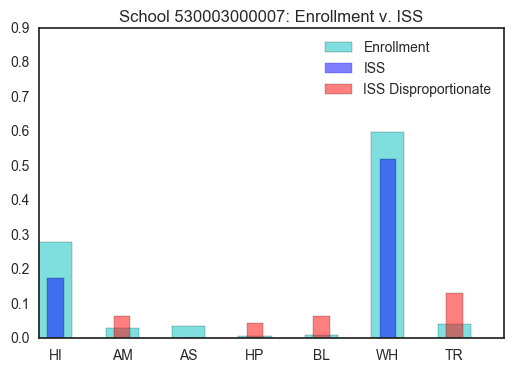

In [155]:
# Plot in school suspension proportions for school 7
enrollment = enrollment_wodis_proportions.iloc[6,:-3].values
discipline = iss_wodis_proportions.iloc[6,:-3].values
iss6 = plot_proportions(enrollment_proportions = enrollment, disc_proportions = discipline,index=race_abbreviations,disc_label='ISS');

In [156]:
disc_proportions = iss_wodis_proportions.iloc[6,:-3]
disc_total = iss_wodis_clean.iloc[6,:-3]
enrollment_proportions = enrollment_wodis_proportions.iloc[6,:-3]
iss6_table = construct_presentation_table(disc_proportions,disc_total,enrollment_proportions)
print iss6_table

    Composition Index  Distribution  Total
HI               0.62          0.17      8
AM               2.23          0.07      3
AS               0.00          0.00      0
HP               6.53          0.04      2
BL               7.00          0.07      3
WH               0.87          0.52     24
TR               3.16          0.13      6


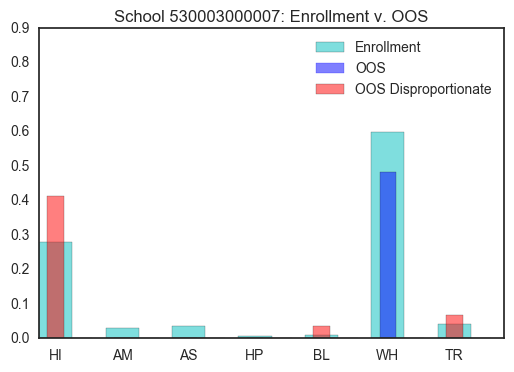

In [157]:
# Plot out of school suspension proportions for school 7
enrollment = enrollment_wodis_proportions.iloc[6,:-3].values
discipline = oos_wodis_proportions.iloc[6,:-3].values
oos6 = plot_proportions(enrollment,discipline,index=race_abbreviations,disc_label='OOS');

In [158]:
disc_proportions = oos_wodis_proportions.iloc[6,:-3]
disc_total = oos_wodis_clean.iloc[6,:-3]
enrollment_proportions = enrollment_wodis_proportions.iloc[6,:-3]
oos6_table = construct_presentation_table(disc_proportions,disc_total,enrollment_proportions)
print oos6_table

    Composition Index  Distribution  Total
HI               1.48          0.41     12
AM               0.00          0.00      0
AS               0.00          0.00      0
HP               0.00          0.00      0
BL               3.70          0.03      1
WH               0.81          0.48     14
TR               1.67          0.07      2


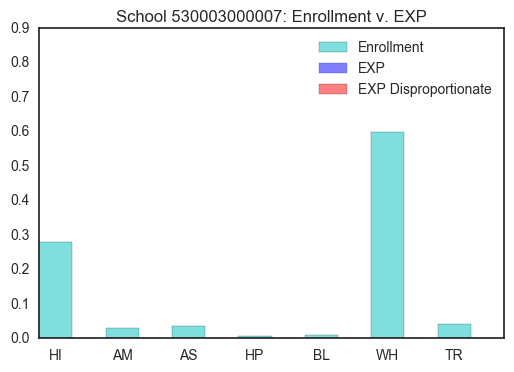

In [159]:
# Plot expulsion proportions for school 7
enrollment = enrollment_wodis_proportions.iloc[6,:-3].values
discipline = exp_wodis_proportions.iloc[6,:-3].values
exp6 = plot_proportions(enrollment,discipline,index=race_abbreviations,disc_label='EXP');

In [160]:
disc_proportions = exp_wodis_proportions.iloc[6,:-3]
disc_total = exp_wodis_clean.iloc[6,:-3]
enrollment_proportions = enrollment_wodis_proportions.iloc[6,:-3]
exp6_table = construct_presentation_table(disc_proportions,disc_total,enrollment_proportions)
print exp6_table

    Composition Index  Distribution  Total
HI                NaN           NaN      0
AM                NaN           NaN      0
AS                NaN           NaN      0
HP                NaN           NaN      0
BL                NaN           NaN      0
WH                NaN           NaN      0
TR                NaN           NaN      0


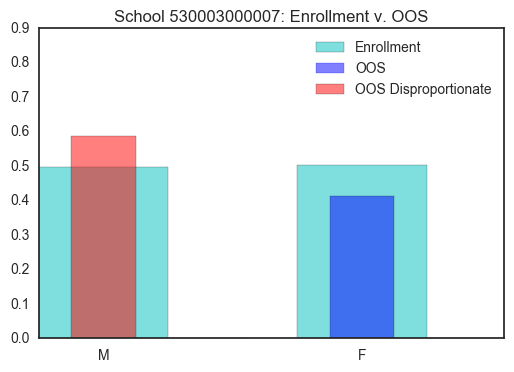

In [161]:
# Plot out of school suspension proportions for school 7 by gender
enrollment = enrollment_wodis_proportions.iloc[6,-3:-1].values
discipline = oos_wodis_proportions.iloc[6,-3:-1].values
oos6_gender = plot_proportions(enrollment, discipline,index=gender,disc_label='OOS');

Next the report is constructed using HTML.

,Composition Index,Distribution,Total
HI,0.62,0.17,8
AM,2.23,0.07,3
AS,0.00,0.00,0
HP,6.53,0.04,2
BL,7.00,0.07,3
WH,0.87,0.52,24
TR,3.16,0.13,6
,Composition Index,Distribution,Total
HI,1.48,0.41,12
AM,0.00,0.00,0

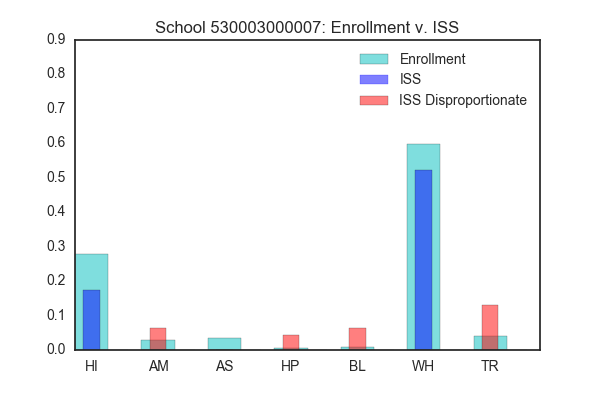
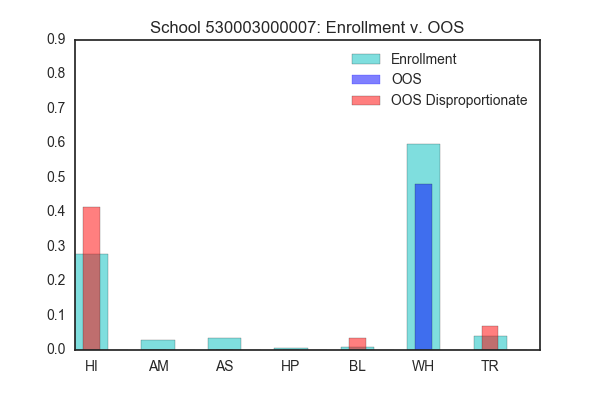
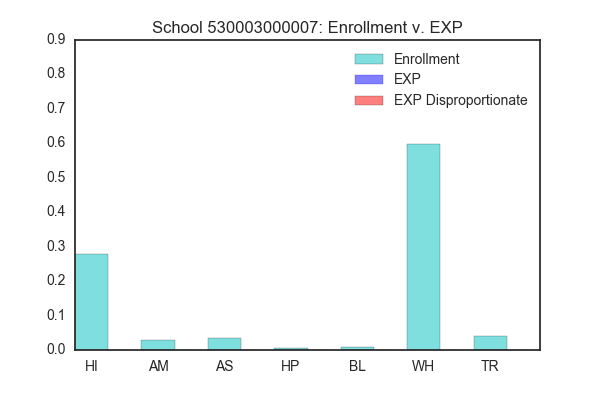

In [162]:
from IPython.display import display, HTML
from jinja2 import Environment, FileSystemLoader

# Initialize a jinja environment
env = Environment(loader=FileSystemLoader('.'))
template = env.get_template("reportcard.html")

# template for each graph
image_template = """
        <div class='image'>
            <img src={source}>
            {presentation_table}
        </div>
"""

images = [(iss6,iss6_table),(oos6,oos6_table),(exp6,exp6_table)]

# construct html for each graph
content = ''
for image, table in images:
    _ = image_template
    table_html = table.to_html(justify='right').replace('border="1"','border="0"')
    content += _.format(source=image,presentation_table=table_html)
    save_table = table

# construct html for report
template_vars = {'title':'Composition Index Report for School {}'.format('placeholder'),'images':content}
report_html = template.render(template_vars)

display(HTML(report_html))

In [163]:
palette = sns.color_palette()[5]
rgb = tuple([255*x for x in palette])
rgb

(100.0, 181.0, 205.0)

In [164]:
# Convert the html to a pdf. This only works locally right now.
import pdfkit
wkpath = r'C:\Program Files\wkhtmltopdf\bin\wkhtmltopdf.exe'
config = pdfkit.configuration(wkhtmltopdf=wkpath)
pdfkit.from_string(report_html,output_file,configuration=config,css='style.css')

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                      


True